# arXiv Analyis

## Overview
[arXiv](https://arxiv.org/) is a free distritbution service and open-access archive with over 2 million scholarly articles in mathematics, computer science, physics, and many other STEM fields. I frequently used this service in college when searching for research papers. In this project, I collected data on all papers in the archive in order to study trends in different research areas and identify popular subjects. Some questions I want to answer in this project are:
1. What are the most popular research areas over time and how have they changed. 
2. What are frequently used buzzwords in paper titles among the different research areas?
3. Many papers have multiple subject tags. What subjects have the most overlap?


In [32]:
import pandas as pd
import numpy as np
import sqlite3
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from nltk.util import ngrams
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import sys

In [ ]:
# conn = sqlite3.connect('arxiv_metadata.db')
# df = pd.read_sql_query("SELECT * FROM arxiv_metadata", conn)

In [25]:
df = pd.read_csv("arxiv_sample.csv")

In [26]:
df['published'] = pd.to_datetime(df['published'])

# Extract year from 'published' column
df['year'] = df['published'].dt.year

# Group by year and count the number of papers published each year
papers_per_year = df['year'].value_counts().sort_index()

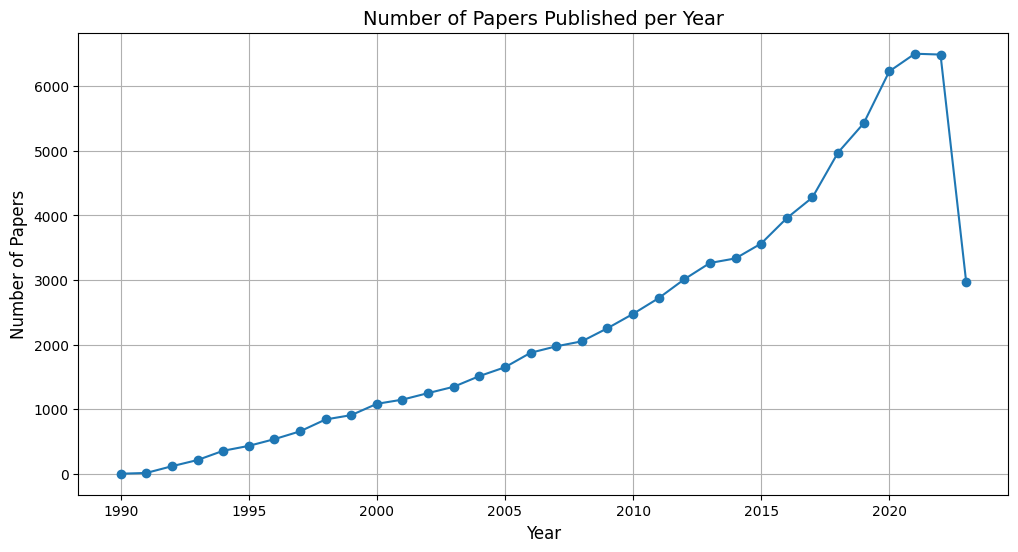

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(papers_per_year.index, papers_per_year.values, marker='o')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Papers', fontsize=12)
plt.title('Number of Papers Published per Year', fontsize=14)
plt.grid(True)
plt.show()

Above is a line graph that shows the number of papers published per year from 1990 to 2023. The x-axis represents the year, and the y-axis represents the number of papers published that year. We can see here that the number of papers published per year has been steadily increasing over time, with a few exceptions. This suggests a growing interest and activity in academic research over the years. Note that the count for 2023 is lower because we do not have data for the whole year.

In [28]:
# Split the subject tags by space character to handle papers with multiple subjects
df['subject'] = df['subject'].str.split()

# Get the most recent date in the data
most_recent_date = df['published'].max()

# Calculate the date 12 months before the most recent date
one_year_ago = most_recent_date - pd.DateOffset(years=1)

# Filter the DataFrame to only include papers published in the last 12 months
df_last_12_months = df[df['published'] > one_year_ago]

# Count the occurrences of each subject in the last 12 months
subject_counts_last_12_months = df_last_12_months.explode('subject')['subject'].value_counts()

# Count the occurrences of each subject overall
subject_counts = df.explode('subject')['subject'].value_counts()

# Add a column to the subject_counts DataFrame for the number of papers published in the last 12 months
subject_counts_df = subject_counts.head(20).rename('Total Papers').to_frame()
subject_counts_df['Papers Last 12 Months'] = subject_counts_df.index.map(subject_counts_last_12_months.to_dict())
subject_counts_df = subject_counts_df.fillna(0).astype({'Papers Last 12 Months': 'int'})

subject_counts_df

,Total Papers,Papers Last 12 Months
subject,,
hep-ph,6007,254
hep-th,5512,261
cs.LG,5007,995
quant-ph,4765,392
astro-ph,3612,0
gr-qc,3487,218
cs.CV,3464,770
cond-mat.mtrl-sci,2928,224
cond-mat.mes-hall,2913,173


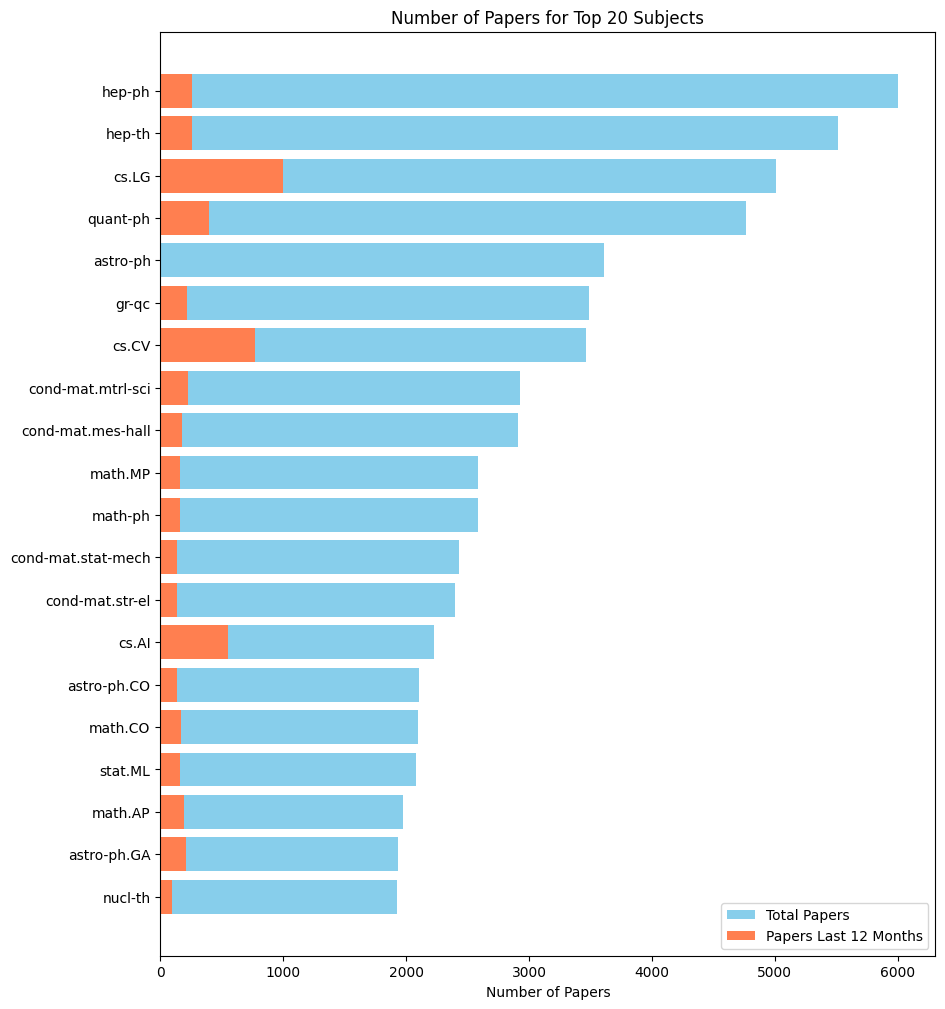

In [29]:
# Create a DataFrame for plotting
plot_df = subject_counts_df.sort_values('Total Papers')

# Initialize the figure and axes
fig, ax = plt.subplots(figsize=(10, 12))

# Create a bar plot for 'Total Papers'
ax.barh(plot_df.index, plot_df['Total Papers'], color='skyblue', label='Total Papers')

# Create a bar plot for 'Papers Last 12 Months' on top of the first plot
ax.barh(plot_df.index, plot_df['Papers Last 12 Months'], color='coral', label='Papers Last 12 Months')

# Set labels and title
ax.set_xlabel('Number of Papers')
ax.set_title('Number of Papers for Top 20 Subjects')

# Add a legend
ax.legend()

plt.show()

In [21]:
# Convert 'published' column to datetime and extract year
df['published'] = pd.to_datetime(df['published'])
df['year'] = df['published'].dt.year

# Group by year and subject, and count the occurrences of each subject per year
subject_counts_per_year = df.explode('subject').groupby('year')['subject'].value_counts().unstack().fillna(0)

# Get the most popular subject for each year
most_popular_subject_per_year = subject_counts_per_year.idxmax(axis=1)

most_popular_subject_per_year

year
1990       cs.GR
1991      hep-th
1992      hep-th
1993      hep-th
1994      hep-ph
1995      hep-th
1996      hep-ph
1997      hep-ph
1998    astro-ph
1999    astro-ph
2000    astro-ph
2001    astro-ph
2002    astro-ph
2003    astro-ph
2004    astro-ph
2005    astro-ph
2006    astro-ph
2007    astro-ph
2008    astro-ph
2009      hep-ph
2010      hep-ph
2011      hep-ph
2012      hep-ph
2013      hep-ph
2014      hep-ph
2015      hep-ph
2016      hep-ph
2017    quant-ph
2018       cs.LG
2019       cs.LG
2020       cs.LG
2021       cs.LG
2022       cs.LG
2023       cs.LG
dtype: object

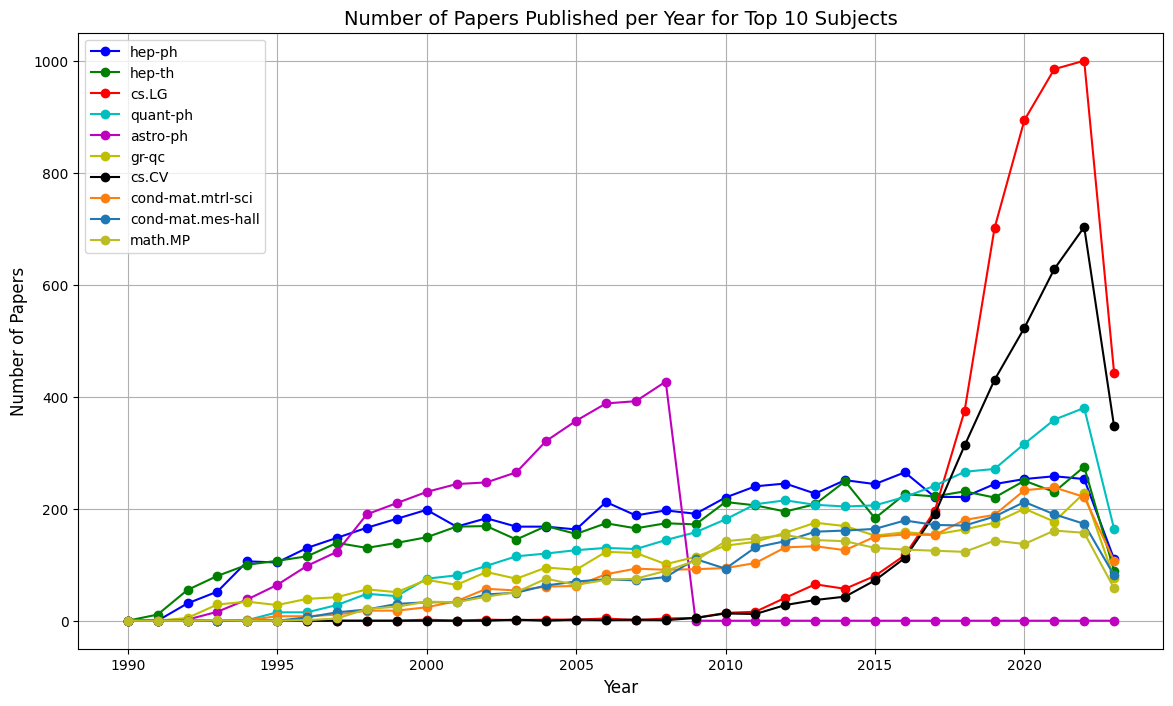

In [23]:
# Get the top 10 subjects overall
top_10_subjects = subject_counts.head(10).index

# Filter the DataFrame to only include the top 10 subjects
top_10_subject_counts_per_year = subject_counts_per_year[top_10_subjects]

# Set a color palette with contrasting colors
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', '#ff7f0e', '#1f77b4', '#bcbd22']

# Plot the data with the new color palette
plt.figure(figsize=(14, 8))
for i, subject in enumerate(top_10_subjects):
    plt.plot(top_10_subject_counts_per_year.index, top_10_subject_counts_per_year[subject], marker='o', color=colors[i], label=subject)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Papers', fontsize=12)
plt.title('Number of Papers Published per Year for Top 10 Subjects', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

In [33]:
# Create a DataFrame where each row corresponds to a paper and each column corresponds to a subject, 
# with a value of 1 if the paper has that subject and 0 otherwise
subject_df = df['subject'].apply(lambda subjects: pd.Series([1]*len(subjects), index=subjects)).fillna(0)

# Compute the matrix of subject co-occurrences
co_occurrence_matrix = subject_df.T.dot(subject_df)

# Fill the diagonal with 0s (we are not interested in how many times each subject appears by itself)
np.fill_diagonal(co_occurrence_matrix.values, 0)

# Get the pairs of subjects with the highest co-occurrence
co_occurrence_pairs = co_occurrence_matrix.unstack()
top_co_occurrence_pairs = co_occurrence_pairs.sort_values(ascending=False).head(20)

top_co_occurrence_pairs

math-ph  math.MP    2585.0
math.MP  math-ph    2585.0
cs.LG    stat.ML    1746.0
stat.ML  cs.LG      1746.0
gr-qc    hep-th     1508.0
hep-th   gr-qc      1508.0
cs.IT    math.IT    1496.0
math.IT  cs.IT      1496.0
hep-ph   hep-th     1027.0
hep-th   hep-ph     1027.0
cs.LG    cs.AI      1004.0
cs.AI    cs.LG      1004.0
cs.LG    cs.CV       959.0
cs.CV    cs.LG       959.0
hep-ph   nucl-th     920.0
nucl-th  hep-ph      920.0
hep-ph   hep-ex      835.0
hep-ex   hep-ph      835.0
math.ST  stat.TH     762.0
stat.TH  math.ST     762.0
dtype: float64

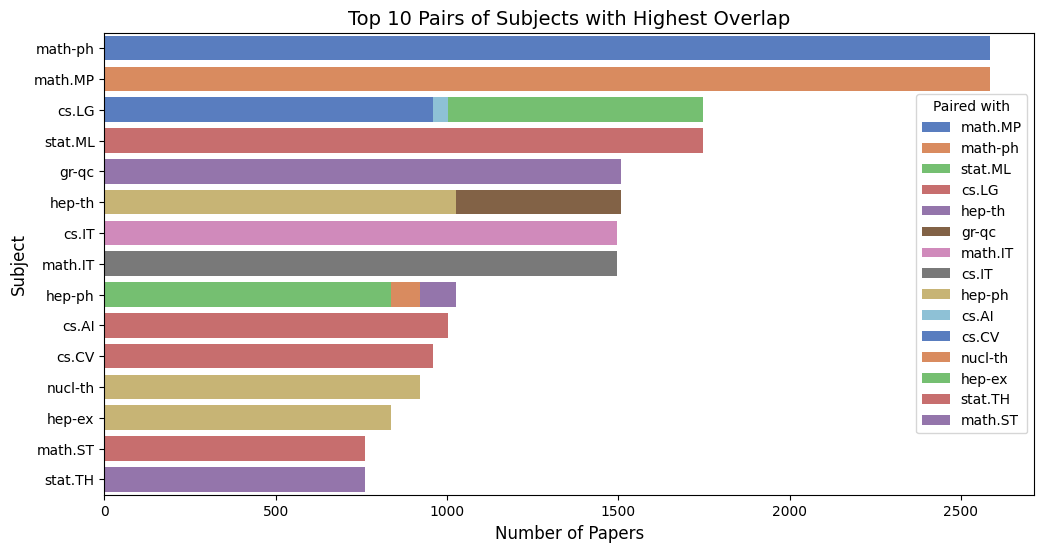

In [34]:
# Convert the series to a DataFrame and reset the index
top_pairs_df = top_co_occurrence_pairs.to_frame().reset_index()

# Rename the columns
top_pairs_df.columns = ['Subject 1', 'Subject 2', 'Number of Papers']

# Make the plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Number of Papers', y='Subject 1', hue='Subject 2', data=top_pairs_df, dodge=False, palette='muted')
plt.xlabel('Number of Papers', fontsize=12)
plt.ylabel('Subject', fontsize=12)
plt.title('Top 10 Pairs of Subjects with Highest Overlap', fontsize=14)
plt.legend(title='Paired with')
plt.show()

In [14]:

stop_words_extended = list(ENGLISH_STOP_WORDS) + [
        'model', 'data', 'results', 'using', 'based', 'time', 'field', 'paper', 'models',
        'quantum', 'study', 'energy', 'method', 'new', 'state', 'non', 'high', 'present',
        'theory', 'different', 'one', 'two', 'also', 'use', 'show', 'analysis', 'result',
        'approach', 'used', 'research', 'study', 'system', 'number', 'effect', 'case',
        'process', 'work', 'can', 'consider', 'problem', 'first', 'well', 'proposed', 'provide',
        'paper', 'may', 'properties', 'three', 'given', 'results', 'specific', 'function',
        'general', 'discuss', 'value', 'values', 'part', 'form', 'structure', 'terms',
        'known', 'similar', 'found', 'example', 'point', 'due', 'area', 'level', 'however',
        'large', 'thus', 'order', 'applied', 'within', 'shown', 'second', 'four', 'article',
        'described', 'type', 'likely', 'less', 'presented', 'following', 'either', 'across',
        'among', 'multiple', 'whether', 'per', 'without', 'small', 'significant', 'possible',
        'since', 'including', 'might', 'main', 'major', 'many', 'several', 'total', 'often',
        'higher', 'although', 'both', 'low', 'between', 'much', 'issue', 'called', 'particular',
        'important', 'made', 'next', 'real', 'open', 'early', 'least', 'done', 'common', 'lead',
        'led', 'far', 'certain', 'past', 'individual', 'specifically', 'already', 'moving',
        'short', 'therefore', 'rather', 'while', 'yet', 'before', 'five', 'simple', 'came',
        'tend', 'latest', 'wide', 'less', 'usually', 'greater', 'highly', 'named', 'closely',
        'mostly', 'especially', 'likely', 'recently', 'largely', 'earlier', 'directly',
        'primarily', 'nearly', 'slightly', 'somewhat', 'briefly', 'approximately', 'actively',
        'frequently', 'currently', 'normally', 'fully', 'originally', 'rarely', 'occasionally',
        'somewhere', 'elsewhere', 'previously', 'hardly', 'mostly', 'ultimately', 'mostly', 'later'
    ]



# Define a function to remove numbers from text
def remove_numbers(text):
    return re.sub(r'\b\d+\b', '', text)

# Remove numbers from the 'title' and 'abstract' columns
df['title'] = df['title'].apply(remove_numbers)
df['abstract'] = df['abstract'].apply(remove_numbers)

# Initialize a CountVectorizer
vectorizer = CountVectorizer(stop_words=stop_words_extended)

# Fit the vectorizer to the 'title' and 'abstract' columns
titles = vectorizer.fit_transform(df['title'])
abstracts = vectorizer.fit_transform(df['abstract'])

# Get the feature names (words) and their counts
title_words = vectorizer.get_feature_names_out()
title_counts = titles.sum(axis=0).A1
abstract_words = vectorizer.get_feature_names_out()
abstract_counts = abstracts.sum(axis=0).A1

# Create Counters for the words in titles and abstracts
title_counter = Counter(dict(zip(title_words, title_counts)))
abstract_counter = Counter(dict(zip(abstract_words, abstract_counts)))

# Get the 20 most common words in titles and abstracts
title_common_words = title_counter.most_common(20)
abstract_common_words = abstract_counter.most_common(20)

title_common_words, abstract_common_words

([('chromophilic', 2743),
  ('eskridge', 2285),
  ('countermeasures', 1911),
  ('ellipticites', 1899),
  ('articulated', 1572),
  ('coadmissible', 1459),
  ('auac', 1444),
  ('continuities', 1438),
  ('decelle11', 1337),
  ('baggage', 1208),
  ('counterproductive', 1194),
  ('counterknots', 1171),
  ('aplc', 1162),
  ('disambiguates', 1149),
  ('electromagnetically', 1132),
  ('arcmin2', 1100),
  ('civilisation', 1084),
  ('7y', 1075),
  ('enantiomers', 1072),
  ('cohomolohgy', 1064)],
 [('systems', 13929),
  ('space', 13725),
  ('mass', 13191),
  ('phase', 11560),
  ('learning', 11391),
  ('methods', 10832),
  ('magnetic', 10320),
  ('spin', 10103),
  ('dimensional', 10052),
  ('network', 10022),
  ('states', 9710),
  ('information', 9697),
  ('set', 9646),
  ('density', 9621),
  ('performance', 9531),
  ('algorithm', 9473),
  ('propose', 9436),
  ('distribution', 9028),
  ('linear', 8496),
  ('observed', 8404)])

In [15]:

# Define a TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words=stop_words_extended, max_features=1000)

# Fit the vectorizer to the 'title' and 'abstract' columns
titles_tfidf = vectorizer.fit_transform(df['title'])
abstracts_tfidf = vectorizer.fit_transform(df['abstract'])

# Get the feature names (words) and their scores
title_words_tfidf = vectorizer.get_feature_names_out()
title_scores_tfidf = titles_tfidf.sum(axis=0).A1
abstract_words_tfidf = vectorizer.get_feature_names_out()
abstract_scores_tfidf = abstracts_tfidf.sum(axis=0).A1

# Create Dictionaries for the words in titles and abstracts
title_dict_tfidf = dict(zip(title_words_tfidf, title_scores_tfidf))
abstract_dict_tfidf = dict(zip(abstract_words_tfidf, abstract_scores_tfidf))

# Get the 20 most important words in titles and abstracts based on TF-IDF scores
title_important_words_tfidf = sorted(title_dict_tfidf.items(), key=lambda x: x[1], reverse=True)[:20]
abstract_important_words_tfidf = sorted(abstract_dict_tfidf.items(), key=lambda x: x[1], reverse=True)[:20]

title_important_words_tfidf, abstract_important_words_tfidf

([('jet', 1036.6283930101777),
  ('surfaces', 866.3328821139098),
  ('momentum', 755.5025746970797),
  ('spaces', 680.0572754919237),
  ('distinct', 619.6988279409455),
  ('despite', 618.9186470476939),
  ('light', 568.3329798327485),
  ('mode', 552.1540401559834),
  ('partial', 515.9117593525635),
  ('moment', 498.9530958871102),
  ('energies', 483.2285237380076),
  ('decision', 481.86877534258275),
  ('monte', 478.8426336864966),
  ('flat', 478.0908956868828),
  ('single', 474.4441125453957),
  ('dependence', 471.02823764288877),
  ('layers', 451.49650125324183),
  ('quality', 449.8239262157168),
  ('end', 446.98936196763606),
  ('spin', 444.4269962233982)],
 [('space', 1267.084937601094),
  ('systems', 1260.5172336017974),
  ('phase', 1098.0628761011071),
  ('mass', 1078.2958767959874),
  ('spin', 1062.4339948107697),
  ('magnetic', 1040.3509144007387),
  ('dimensional', 1037.5841805594225),
  ('learning', 1009.3731738752899),
  ('states', 1005.8053420705912),
  ('methods', 962.9375